In [1]:
import yaml
from easydict import EasyDict

import jax
import jax.random as random
from jax import numpy as jnp
import numpy as np

from dibs.target import make_graph_model, Data
from dibs.models import DenseNonlinearGaussian
from dibs.utils import visualize_ground_truth

from dibs.inference import MarginalDiBS, JointDiBS

from causal_env_v0 import CausalEnv_v0
from policy import RandomPolicy, FixedInterventionPolicy
from utils import collect_observational_data
from hypotheses import *

/workspace/rochan/envs/work/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.0.0)/charset_normalizer (2.0.7) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
Detecting 2 CUDA device(s).


In [2]:
def make_data_env(env, num_samples, env_config, key):

    # initialize random policy
    random_policy = RandomPolicy(action_space=env.action_space)

    # Create numpy array to store training data
    x = np.zeros((num_samples, 4))

    # Define simple method to collect training data
    def store_state(
        *, state, action, next_state, reward, done, info, t_step, store_eps_info
    ) -> None:
        x[t_step, :] = np.concatenate([action, next_state[-1:]]).astype(np.float32) + \
                            np.random.normal(0, 0.1, 4)

    # collect training (observational) data from environment
    collect_observational_data(
        env_config=env_config,
        num_samples=num_samples,
        store_observational_data_callback=store_state,
        store_eps_info=False,
        policy=random_policy,
    )

    # Create numpy array to store training data
    x_ho = np.zeros((num_samples, 4))

    # Define simple method to collect training data
    def store_state(
        *, state, action, next_state, reward, done, info, t_step, store_eps_info
    ) -> None:
        x_ho[t_step, :] = np.concatenate([action, next_state[-1:]]).astype(np.float32) + \
                            np.random.normal(0, 0.1, 4)

    # collect training (observational) data from environment
    collect_observational_data(
        env_config=env_config,
        num_samples=num_samples,
        store_observational_data_callback=store_state,
        store_eps_info=False,
        policy=random_policy,
    )

    # Create numpy array to store training data
    x_interv = []

    # Define simple method to collect training data
    def store_state(
        *, state, action, next_state, reward, done, info, t_step, store_eps_info
    ) -> None:
        x_interv.append((action, np.concatenate([action, next_state[-1:]]).astype(np.float32)
        ))

    # collect training (observational) data from environment
    collect_observational_data(
        env_config=env_config,
        num_samples=num_samples,
        store_observational_data_callback=store_state,
        store_eps_info=False,
        policy=random_policy,
    )

    data = Data(
        passed_key=key,
        n_vars=4,
        n_observations=num_samples,
        n_ho_observations=num_samples,
        g=jnp.array(ABC),
        theta=None,
        x=x,
        x_ho=x_ho,
        x_interv=x_interv,
    )

    return data

In [3]:
key = random.PRNGKey(123)
print(f"JAX backend: {jax.default_backend()}")

key, subk = random.split(key)

JAX backend: gpu


In [4]:
graph_dist = make_graph_model(n_vars=4, graph_prior_str="", edges_per_node=1)
inference_model = DenseNonlinearGaussian(hidden_layers=[10, 10, 10], activation="leakyrelu", graph_dist=graph_dist)

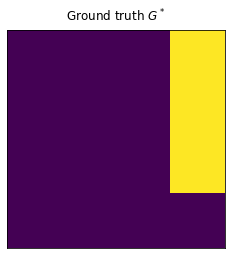

In [5]:
# Load env config
with open('config/env_config.yaml', "r") as f:
    env_config = EasyDict(yaml.load(f, Loader=yaml.FullLoader))
    ldict = {}
    exec(env_config.hypotheses, globals(), ldict)
    env_config.hypotheses = ldict["hypotheses"]

env_config = env_config
env = CausalEnv_v0(env_config)
agent = RandomPolicy(action_space=env.action_space)

data = make_data_env(env=env, num_samples=1000, env_config=env_config, key=key)

visualize_ground_truth(data.g)

In [6]:
inter_mask = np.concatenate([np.ones((1000, 1)), np.ones((1000, 1)), np.ones((1000, 1)), np.zeros((1000, 1))], axis=-1).astype(np.int32)

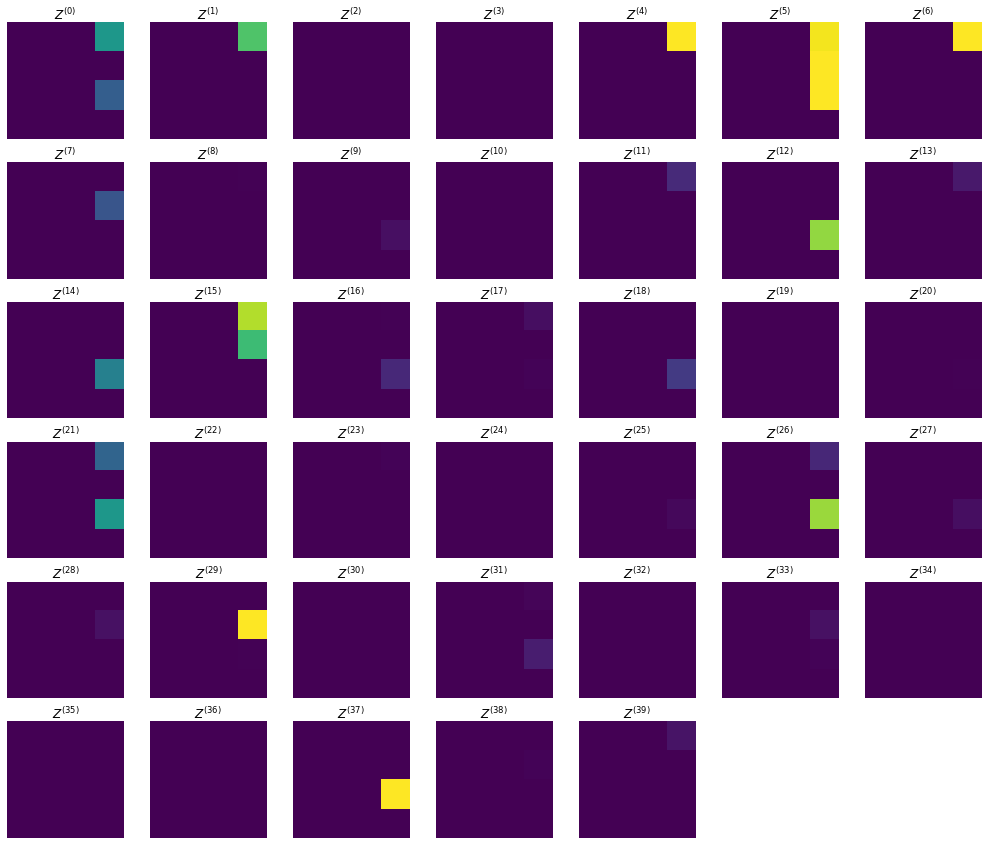

iteration   2000 | alpha  100.0 | beta 2000.0 | #cyclic   0


In [7]:
dibs = JointDiBS(x=data.x, interv_mask=inter_mask, inference_model=inference_model, verbose=True)
key, subk = random.split(key)

gs, theta, z = dibs.sample(key=subk, n_particles=40, steps=2000, callback_every=20, return_z=True, callback=dibs.visualize_callback())

In [16]:
for i in [A, B, C, AB, BC, CA, ABC]:
	print(f"p({i}) = {dibs.latent_log_prob(i, z, t=2000)}")

p([[0 0 0 1]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]) = -1087.5086669921875
p([[0 0 0 0]
 [0 0 0 1]
 [0 0 0 0]
 [0 0 0 0]]) = -1795.4857177734375
p([[0 0 0 0]
 [0 0 0 0]
 [0 0 0 1]
 [0 0 0 0]]) = -1481.3138427734375
p([[0 0 0 1]
 [0 0 0 1]
 [0 0 0 0]
 [0 0 0 0]]) = -2556.22509765625
p([[0 0 0 0]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 0]]) = -2950.030029296875
p([[0 0 0 1]
 [0 0 0 0]
 [0 0 0 1]
 [0 0 0 0]]) = -2242.052978515625
p([[0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 0]]) = -3710.769287109375


In [17]:
u, v = z[..., 0], z[..., 1]
print(f"u: {u.shape}")
print(f"v: {v.shape}")

u: (40, 4, 4)
v: (40, 4, 4)


In [24]:
import matplotlib.pyplot as plt

def m3():
    grid = np.zeros((40, 4, 4))

    for k in range(40):
        for i in range(4):
            for j in range(4):

                Z = jnp.concatenate([u[k, i, :], v[k, i, :]], axis=0)
                Z_norm = jnp.expand_dims(jnp.linalg.norm(Z), axis=0)

                B = jnp.concatenate([u[k, j, :], v[k, j, :]], axis=0).T
                B_norm = jnp.expand_dims(jnp.linalg.norm(B), axis=0)

                cosine_similarity = ((Z @ B.T) / (Z_norm @ B_norm)).T
                cosine_distance = 1 - cosine_similarity
                # print(f"{i},{j} : {cosine_distance}")
                grid[k, i, j] = cosine_distance

    #     plt.matshow(grid[k, :, :])
    #     plt.colorbar()
    #     plt.tight_layout()
    #     plt.savefig(f'cbed/output/{k}-grid.png')

    # plt.matshow(grid.mean(axis=0))
    # plt.colorbar()
    # plt.tight_layout()
    # plt.savefig(f'cbed/output/grid.png')
    return grid

In [25]:
scores = jnp.einsum('...ik,...jk->...ij', u, v)

grid = m3()

In [26]:
dibs_empirical = dibs.get_empirical(gs, theta)
dibs_mixture = dibs.get_mixture(gs, theta)
print(f"Joint posterior log prob: {dibs_mixture.logp}")

Joint posterior log prob: [-335.06567 -300.46362 -363.33838 -411.16846 -442.4867     0.
 -358.29944 -704.8462  -361.98694 -632.41394 -431.52002 -378.04382
 -339.87256 -531.25146 -392.99463 -229.42004 -377.73523 -376.10156
 -374.5719  -399.3462  -387.2057  -629.7383  -358.4812  -374.22498
 -654.46045 -373.80933 -330.82324 -356.08313 -388.35083 -330.09644
 -384.89478 -451.59595 -451.21924 -487.489   -394.0332  -377.95288
 -394.46692 -331.7964  -359.80347 -398.79395]


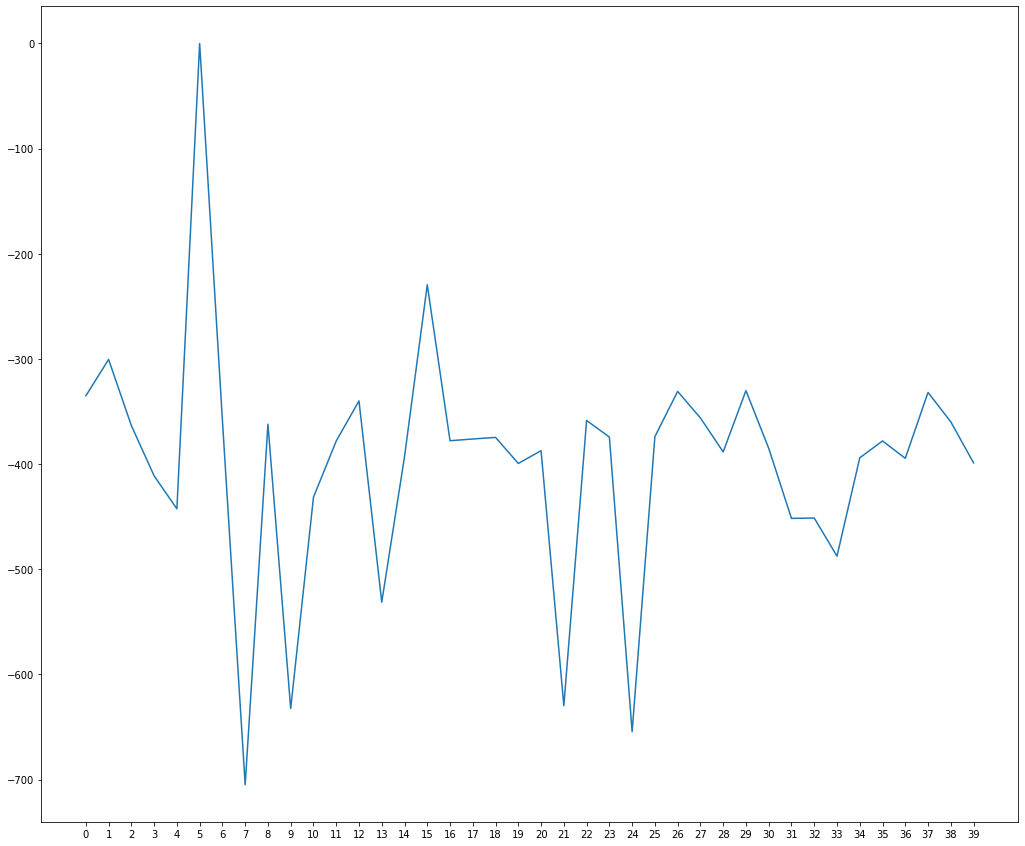

In [27]:
plt.plot(np.arange(40), dibs_mixture.logp)
plt.xticks(np.arange(40))
plt.show()

In [42]:
def plot_grid(grid, n_cols=7, size=2.5):
	N = grid.shape[0]
	n_rows = N // n_cols
	if N % n_cols:
		n_rows += 1

	plt.rcParams['figure.figsize'] = [size * n_cols, size * n_rows]
	fig, axs = plt.subplots(n_rows, n_cols)
	axs = axs.flatten()
	for i, ax in enumerate(axs):
		if i < N:
			ax.matshow(grid[i, :, :])
			ax.tick_params(axis='both', which='both', length=0)
			ax.set_title(r'$Z^{('f'{i}'r')}$', pad=3)
		ax.tick_params(axis='both', which='both', length=0)
		plt.setp(ax.get_xticklabels(), visible=False)
		plt.setp(ax.get_yticklabels(), visible=False)
		ax.axis('off')

	plt.show()

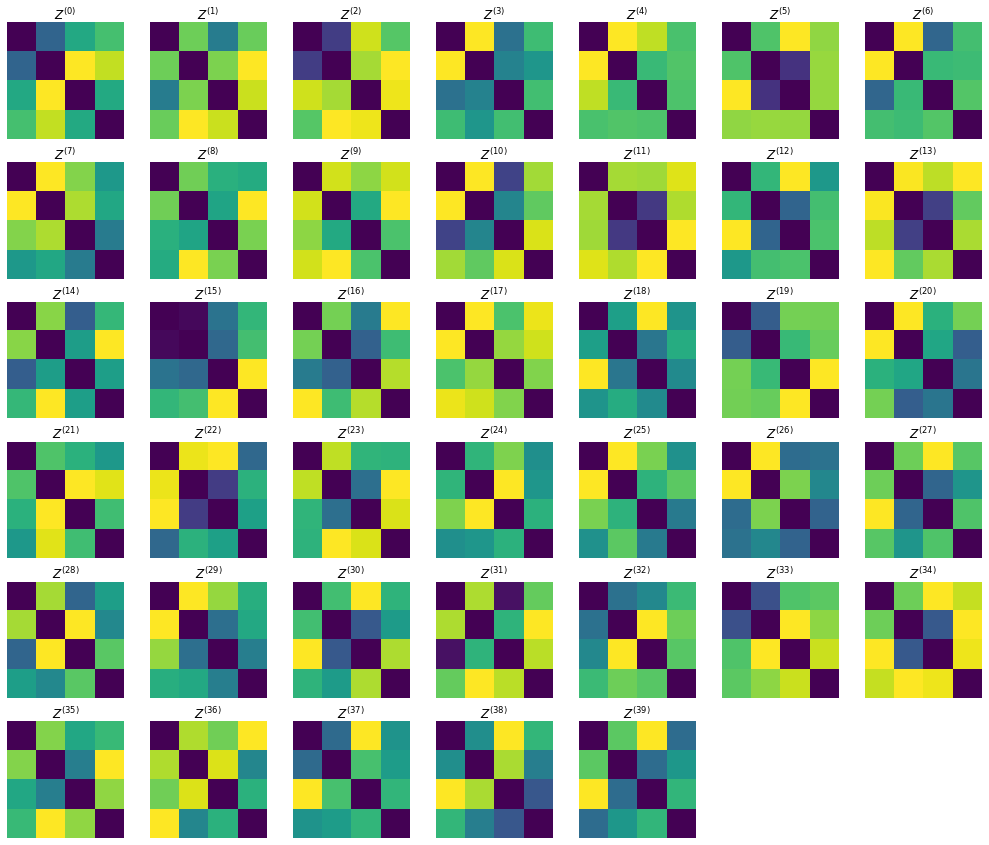

In [43]:
plot_grid(grid)

In [32]:
from dibs.metrics import expected_shd, threshold_metrics, neg_ave_log_likelihood

for descr, dist in [('DiBS ', dibs_empirical), ('DiBS+', dibs_mixture)]:

    eshd = expected_shd(dist=dist, g=data.g)
    auroc = threshold_metrics(dist=dist, g=data.g)['roc_auc']
    negll = neg_ave_log_likelihood(dist=dist, x=data.x_ho,
                eltwise_log_likelihood=dibs.eltwise_log_likelihood_observ)

    print(f'{descr} |  E-SHD: {eshd:4.1f}    AUROC: {auroc:5.2f}    neg. MLL {negll:5.2f}')

DiBS  |  E-SHD:  2.7    AUROC:  1.00    neg. MLL 8322.31
DiBS+ |  E-SHD:  0.0    AUROC:  1.00    neg. MLL 7847.15
